# Electrostatics with Linear Dielectrics

## Import Modules

In [1]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt

## Import Mesh

In [2]:
mesh = fn.Mesh('geometry/dielectric.xml')
subdomains = fn.MeshFunction("size_t", mesh, 'geometry/dielectric_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'geometry/dielectric_facet_region.xml')

## Define Function Spaces

In [3]:
V = fn.FunctionSpace(mesh, 'P', 2)
dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
V0 = fn.FunctionSpace(mesh, 'DG', 0)

## Boundary Conditions

In [4]:
voltage = 100
top = fn.DirichletBC(V, fn.Constant(voltage), boundaries, 3)
bottom = fn.DirichletBC(V, fn.Constant(-voltage), boundaries, 4)
bcs =[top, bottom]

## Define Permittivity User Expression

In [5]:
eps_r = 5

class permittivity(fn.UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 1:
            values[0] = eps_r
        else:
            values[0] = 1

eps = permittivity(subdomains, degree=2)

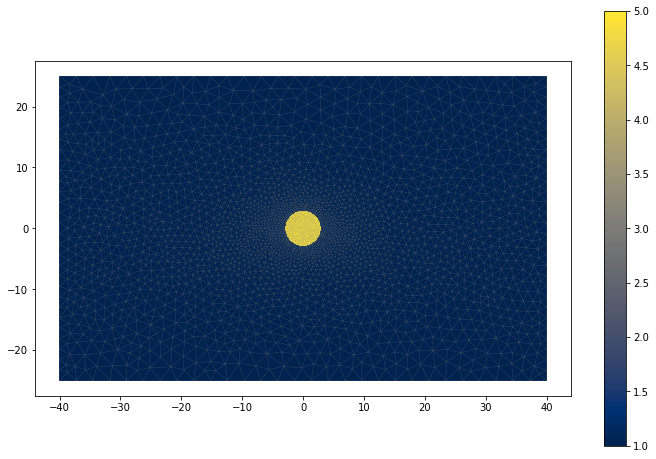

In [6]:
plt.figure(figsize=(12,8))
fn.plot(mesh, linewidth=0.5, alpha=0.35)
p = fn.plot(fn.project(eps, V0), cmap='cividis')
plt.colorbar(p)
plt.show()

### Alternative Method

eps_r = fn.Function(V0)

for n, cell_no in enumerate(subdomains.array()):
    subdomain_no = subdomains.array()[n]
    if subdomain_no == 1:
        value = 1
    else:
        value = 5
        
    eps_r.vector()[n] = value

## Solve Problem

In [7]:
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
a = fn.dot(fn.grad(u), fn.grad(v)) * eps * fn.dx
L = fn.Constant('0') * v * fn.dx
u = fn.Function(V)
fn.solve(a == L, u, bcs)

## Plot Electric Potential

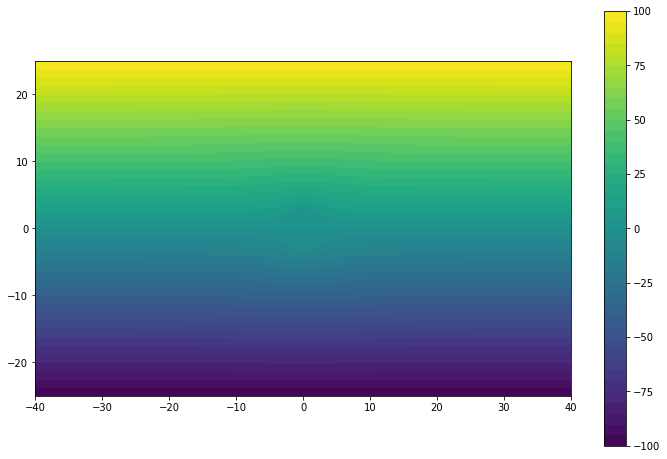

In [8]:
%matplotlib inline
plt.figure(figsize=(12,8))
# fn.plot(mesh, linewidth=0.5, alpha=0.5)
p = fn.plot(u)
plt.colorbar(p)
# plt.savefig('images/output/electric_potential.png', bbox_inches='tight')
plt.show()

## Calculate and Electric Field

In [9]:
electric_field = fn.project(-fn.grad(u))

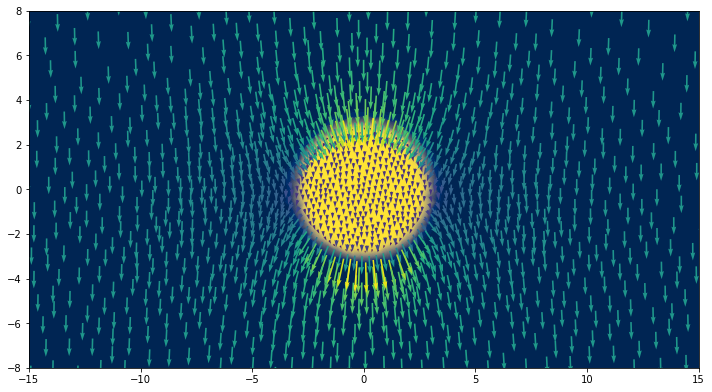

In [10]:
# Zoom in to the region by the dielectric

plt.figure(figsize=(12,8))
fn.plot(fn.project(eps, V), cmap='cividis')
p = fn.plot(electric_field, scale=150)
#plt.colorbar(p)
plt.xlim(-15, 15)
plt.ylim(-8, 8)
# plt.savefig('images/output/electric_field.png', bbox_inches='tight')
plt.show()

# Calculate Field in Dielectric

In [11]:
analytical_field = -2 / (eps_r + 1) * ((2*voltage)/50)
analytical_field

-1.3333333333333333

In [12]:
electric_field((0, 0))[1]

-1.3439346290937293

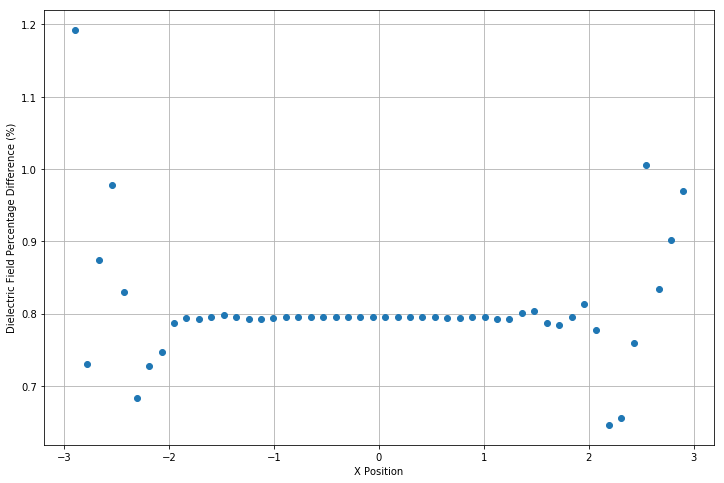

In [13]:
x_pos = np.linspace(-2.9, 2.9, 50)
y_pos = np.zeros(50)

evaluated_field = np.array(list(map(electric_field, zip(x_pos, y_pos))))

plt.figure(figsize=(12, 8))
plt.plot(x_pos, (evaluated_field[:, 1] - analytical_field)/analytical_field * 100, 'o')
plt.xlabel("X Position")
plt.ylabel("Dielectric Field Percentage Difference (%)")
plt.grid()
# plt.savefig('images/output/field_difference.png', bbox_inches='tight')
plt.show()

## Output Results to File

In [14]:
potentialFile = fn.File('output/potential.pvd')
potentialFile << u

vtkfile = fn.File('output/e_field.pvd')
vtkfile << electric_field